In [21]:
# Enable interactive plot
#@formatter:off
%matplotlib inline
%load_ext autoreload
%autoreload 2
#@formatter:on

import logging
log = logging.getLogger()

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from math import ceil

from datasets.RSO_LModule import RSO_LModule
from torch.utils.data import DataLoader

from pqdm.processes import pqdm
from numba import jit
import os

from run import path_resolution
import seaborn as sns
sns.set_theme(style="ticks")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
NUM_WORKERS = 1
DEBUG = False

RUN = False

img_folder = 'imgs'

# path resolution
base_path = path_resolution()

Base path: /Users/yale/Repositories/etap/smart-cities-journal-based-on-jonahs-ma/data/


In [3]:
interm_file = './patches.npz'
RUN = not os.path.isfile(interm_file) or RUN
RUN, interm_file

(False, './patches.npz')

In [4]:
N_PATCHES = 10

In [5]:
data_module = RSO_LModule(data_dir=base_path, n_jobs=1, debug=DEBUG, in_mem=True, batch_size=1, fix_nan=True, shuffle=False)
session_ids = [1] if DEBUG else [1, 2, 3, 4, 5, 6]
all_datasets = data_module._load_datasets(sessions=session_ids)
all_data = torch.utils.data.ConcatDataset(all_datasets)
all_data_loader = DataLoader(all_data, batch_size=1, shuffle=False, num_workers=1)

100%|██████████| 6/6 [00:27<00:00,  4.56s/it]


In [6]:
for realsense, optitrack in all_data_loader:
    print(realsense.shape, optitrack.shape)
    break

TypeError: cannot pickle '_thread.RLock' object

In [7]:
all_datasets[0].optitrack_data

Ab                             Chest                         \
        Position                          Position                          
Frame          X           Y          Z          X           Y          Z   
0      34.911232  102.498116  16.107584  35.102566  117.664268  18.061092   
1      34.911255  102.495071  16.100935  35.107567  117.658165  18.054359   
2      34.909985  102.494904  16.090366  35.108509  117.658875  18.037148   
3      34.906654  102.494957  16.074156  35.108437  117.658401  18.013845   
4      34.904053  102.495766  16.053795  35.104115  117.659447  17.983305   
...          ...         ...        ...        ...         ...        ...   
26694   2.572512   99.832474  18.930128   2.874780  114.380394  21.297070   
26695   1.143206  100.090553  16.349379   1.227071  114.649902  18.697294   
26696  -0.411177  100.690475  13.786022  -0.474266  115.220810  16.118238   
26697  -2.095114  101.285912  11.412931  -2.163943  115.822411  13.650352   
26698  -3.721880  101.677177   9.208651  -3.801463  116.212997  11.312336   

            Head                               Hip  ...  RShoulder     RThigh  \
        Position                          Position  ...   Position   Position   
Frame          X           Y          Z          X  ...          Z          X   
0      34.254826  147.644104  15.279250  34.697842  ...  21.951651  43.865959   
1      34.251488  147.640305  15.268892  34.697655  ...  21.939573  43.865757   
2      34.243488  147.634247  15.236509  34.696449  ...  21.919186  43.864536   
3      34.242786  147.629715  15.194829  34.692921  ...  21.888792  43.860931   
4      34.227776  147.625946  15.145537  34.689236  ...  21.849388  43.857185   
...          ...         ...        ...        ...  ...        ...        ...   
26694   2.113917  144.455612  19.022125   2.678054  ...  23.956131  11.365096   
26695   0.087116  144.747742  16.583263   1.240797  ...  21.425528   9.943723   
26696  -1.935193  145.310287  14.152716  -0.304639  ...  18.942808   8.396120   
26697  -3.830245  145.912155  11.820728  -1.959797  ...  16.583031   6.730126   
26698  -5.623739  146.266678   9.526561  -3.588901  ...  14.362176   5.108497   

                                  RToe                           RUArm  \
                              Position                        Position   
Frame          Y          Z          X         Y          Z          X   
0      94.707199  16.072893  50.566929  4.496662  14.127948  54.588383   
1      94.703903  16.067360  50.564671  4.498981  14.126810  54.595005   
2      94.703789  16.058727  50.565918  4.498118  14.127122  54.599728   
3      94.703514  16.041416  50.564911  4.497473  14.125580  54.606785   
4      94.702995  16.025818  50.565292  4.495665  14.126169  54.610489   
...          ...        ...        ...       ...        ...        ...   
26694  92.335617  16.214571  18.782452  4.465117  31.220150  22.468884   
26695  92.565964  13.738190  18.770275  4.695205  30.950472  20.674820   
26696  93.172768  11.177876  18.728424  5.116483  30.399231  18.870667   
26697  93.811684   8.741262  18.694496  5.645886  29.356703  17.096020   
26698  94.207100   6.542366  18.354937  6.614545  27.620026  15.413420   

                              
                              
Frame           Y          Z  
0      133.739410  20.517035  
1      133.734116  20.504158  
2      133.731659  20.484558  
3      133.724533  20.458763  
4      133.721817  20.424810  
...           ...        ...  
26694  128.610260  18.672184  
26695  129.070221  16.253668  
26696  129.872849  13.953614  
26697  130.702484  11.786323  
26698  131.247849   9.796784  

[26187 rows x 63 columns]

In [8]:
@jit(nopython=True, fastmath=True, nogil=True, parallel=False, cache=False)
def process_helper(inputs, patch_size=5, patch_long=550, number_patches=10):
    step_size = ceil(480/(number_patches+1))
    patch_coordinates = list(range(step_size, 480, step_size))

    # Compute patches   
    patches = [np.mean(inputs[x:x+patch_size, patch_long:patch_long+patch_size]) for x in patch_coordinates]
    # Compute Holes percentage
    holes_percentage = (inputs.size - np.count_nonzero(inputs)) / inputs.size * 100
    return patches, holes_percentage

def process_item(realsense, optitrack):
    with torch.no_grad():
        # Get and prepare inputs
        return process_helper(realsense.numpy().squeeze(axis=1).squeeze(axis=0).astype(np.float32), number_patches=N_PATCHES)


## Calc Realsense background Noise

In [9]:
if RUN:
    # Process data
    res = pqdm(all_data_loader, process_item, n_jobs=NUM_WORKERS, argument_type='args', desc="Processing data", total=len(all_data_loader))
    patches, holes_percentages = zip(*res)
    patches = np.array(patches)
    holes_percentages = np.array(holes_percentages)
    np.savez_compressed(interm_file, patches=patches, holes_percentages=holes_percentages)
else:
    # Load from file
    with np.load(interm_file) as data:
        patches = data["patches"]
        holes_percentages = data["holes_percentages"]

In [10]:
np.round(holes_percentages.std(),3)

0.243

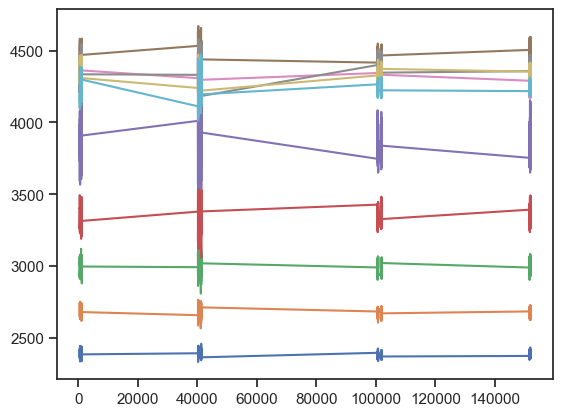

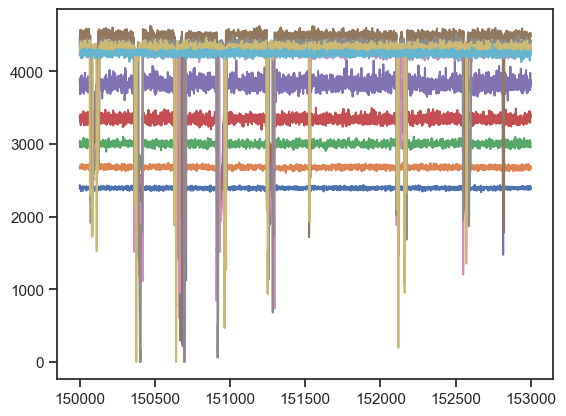

In [11]:
no_testperson_frames = list(range(440,680)) + list(range(900, 1140)) + list(range(40170, 40370)) + list(range(41100, 41300))\
+ list(range(100550, 100770)) + list(range(101745, 101950))  + list(range(151580, 152000))

plt.plot(no_testperson_frames, patches[no_testperson_frames, 0])
plt.plot(no_testperson_frames, patches[no_testperson_frames, 1])
plt.plot(no_testperson_frames, patches[no_testperson_frames, 2])
plt.plot(no_testperson_frames, patches[no_testperson_frames, 3])
plt.plot(no_testperson_frames, patches[no_testperson_frames, 4])
plt.plot(no_testperson_frames, patches[no_testperson_frames, 5])
plt.plot(no_testperson_frames, patches[no_testperson_frames, 6])
plt.plot(no_testperson_frames, patches[no_testperson_frames, 7])
plt.plot(no_testperson_frames, patches[no_testperson_frames, 8])
plt.plot(no_testperson_frames, patches[no_testperson_frames, 9])
plt.show()

start=150000
end=start+3000
x = list(range(start, end))
plt.plot(x, patches[start:end, 0])
plt.plot(x, patches[start:end, 1])
plt.plot(x, patches[start:end, 2])
plt.plot(x, patches[start:end, 3])
plt.plot(x, patches[start:end, 4])
plt.plot(x, patches[start:end, 5])
plt.plot(x, patches[start:end, 6])
plt.plot(x, patches[start:end, 7])
plt.plot(x, patches[start:end, 8])
plt.plot(x, patches[start:end, 9])
plt.show()

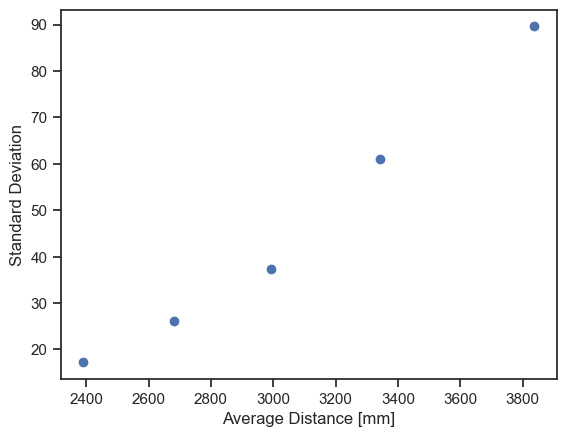

In [14]:
patches_avg_distances = patches[no_testperson_frames].mean(axis=0)[:5]
patches_std = patches[no_testperson_frames].std(axis=0)[:5]

plt.scatter(patches_avg_distances, patches_std)
# for i in range(N_PATCHES):
#     plt.annotate(i, (patches_avg_distances[i], patches_std[i]))

plt.ylabel('Standard Deviation')
plt.xlabel('Average Distance [mm]')
# plt.grid()
plt.savefig(f'{img_folder}/realsense_std.eps')
plt.show()

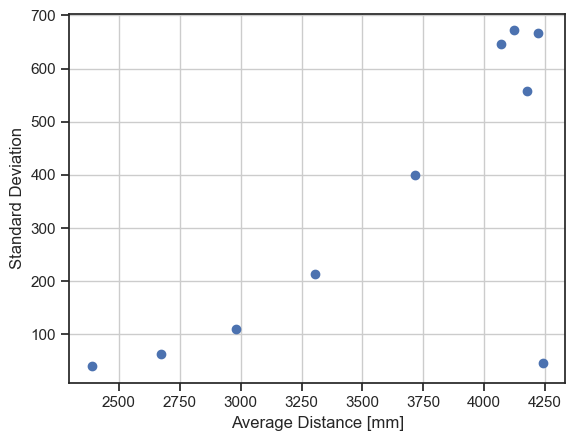

In [15]:
patches_avg_distances = patches.mean(axis=0)
patches_std = patches.std(axis=0)

plt.scatter(patches_avg_distances, patches_std)

plt.ylabel('Standard Deviation')
plt.xlabel('Average Distance [mm]')
plt.grid()
plt.show()

In [35]:
((patches - patches.mean(axis=0)) ** 2).mean(axis=0) ** 0.5

array([ 40.03752871,  64.1067997 , 109.93675788, 213.57595026,
       400.31589083, 666.69157027, 647.21930824, 672.01651163,
       557.98217582,  46.30967983])

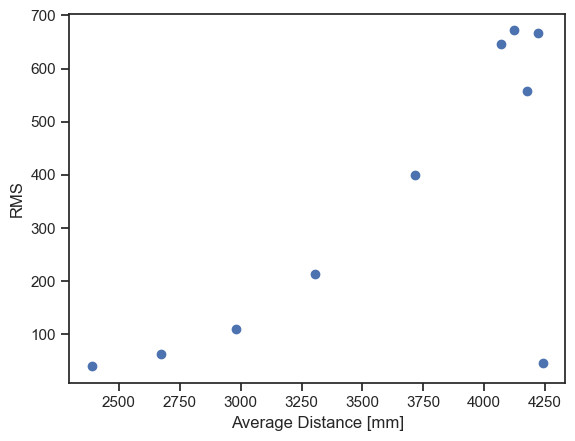

In [16]:
patches_avg_distances = patches.mean(axis=0)
patches_std = (patches - patches_avg_distances).std(axis=0)

plt.scatter(patches_avg_distances, patches_std)

plt.ylabel('RMS')
plt.xlabel('Average Distance [mm]')
plt.show()

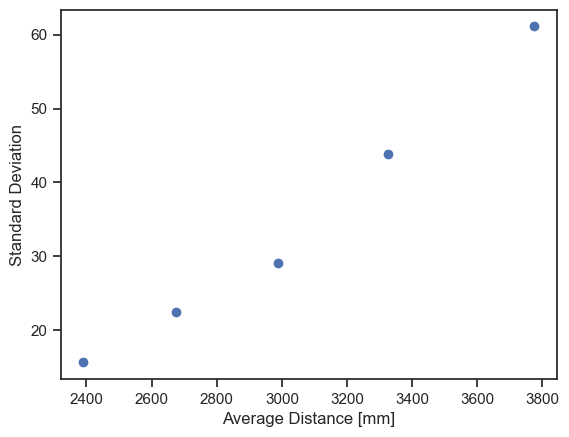

In [18]:
m = patches.mean(axis=0)
patches_avg_distances = patches[np.sum(np.abs(patches - m), axis=1) < N_PATCHES * 100].mean(axis=0)[:5]
patches_std = patches[np.sum(np.abs(patches - m), axis=1) < N_PATCHES * 100].std(axis=0)[:5]

plt.scatter(patches_avg_distances, patches_std)

plt.ylabel('Standard Deviation')
plt.xlabel('Average Distance [mm]')
plt.show()

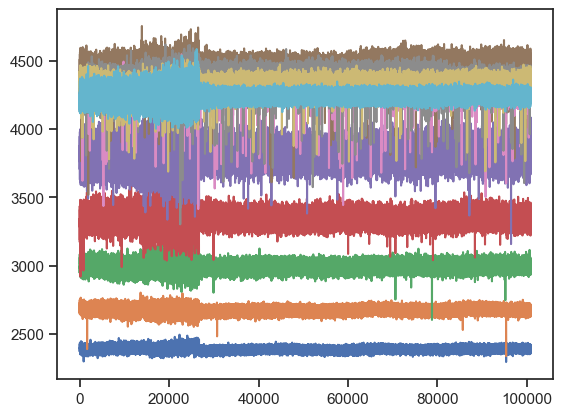

In [19]:
plt.plot(patches[np.sum(np.abs(patches - m), axis=1) < N_PATCHES * 120])

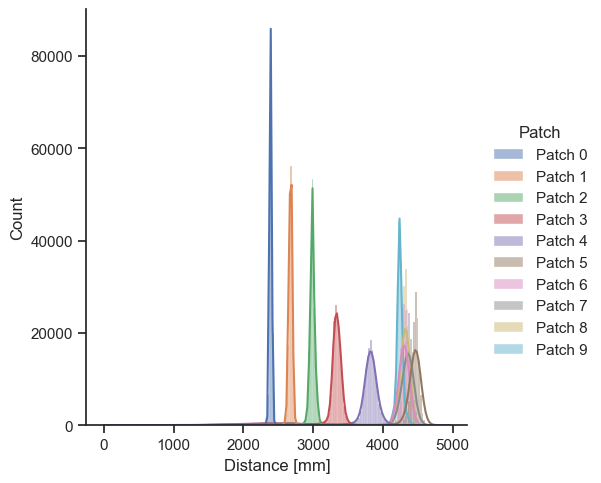

In [22]:
plot_df = pd.DataFrame(patches, columns=[f'Patch {i}' for i in range(N_PATCHES)]).melt(var_name='Patch', value_name='Distance [mm]')
sns.displot(data=plot_df, x="Distance [mm]", hue="Patch", kde=True)